In [ ]:
#
# The MIT License (MIT)

# Copyright (c) 2021, NVIDIA CORPORATION

# Permission is hereby granted, free of charge, to any person obtaining a copy of
# this software and associated documentation files (the "Software"), to deal in
# the Software without restriction, including without limitation the rights to
# use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of
# the Software, and to permit persons to whom the Software is furnished to do so,
# subject to the following conditions:

# The above copyright notice and this permission notice shall be included in all
# copies or substantial portions of the Software.

# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS
# FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR
# COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER
# IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN
# CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.
#

# General statistics of the SIGIR eCommerce Data Challenge dataset, by Coveo
## Based on NVIDIA RecSys Dataset Profiler - v1.0

### Context

This notebook makes it straightforward to assess datasets for recommender systems.
It generates some useful statistics and plots from user interactions datasets, that are useful to decide important aspects of recommender systems like:

- May Collaborative Filtering algorithms (e.g., Matrix Factorization (MF), Neural Collaborative Filtering (NCF)) be suitable for this dataset (e.g. based on the user-item matrix sparsity and on items and users long-tail distribution)?
- Should the recommender system care about recommending items that users have already interacted in the past (like in domains like e-commerce, music)?
- How fast the items loose its relevance for users? That answer is important to define how often we should make fresh items recommendable (e.g., retrain the model)
- Would the session-based / session-aware recommendation task be relevant for this dataset, to deal with item / user cold start problems? How long are the user sessions? How many sessions per user and what time between his sessions?

### How to use
You just need to set some variables from the **Config** section and run the full notebook :)

### Requirements
This notebook uses RAPIDS for GPU-accelerated data analysis. It supports RAPIDS 0.16 or newer.  
You can install RAPIDS with ```conda``` following the examples [here](https://rapids.ai/))

#### Additional dependencies with pip
```
dask-cuda>=0.16.0  
dask-cudf>=0.16.0  
pandas>=1.1.4  
matplotlib>=3.3.4  
```


### Change log
- 2021-02-02 - v1.0 - Initial version - Gabriel Moreira

### Credits
This notebook was created the NVIDIA Merlin team

## Imports

In [1]:
import os
import shutil

In [2]:
import cudf
import pandas as pd
import numpy as np
import cupy as cp
from collections import OrderedDict
from IPython.display import display

In [3]:
import matplotlib.pyplot as plt

In [4]:
from dask.distributed import Client, wait
from dask_cuda import LocalCUDACluster
import dask as dask, dask_cudf
import rmm
from numba import cuda

# Config

## Dataset metadata

In [5]:
#If you change the order of the creation of new keys in the "dataset_info" OrderedDict, 
#the order of the final CSV columns with the dataset profile will change accordingly
dataset_info = OrderedDict()
dataset_info['name'] = 'coveo'
dataset_info['domain'] = 'ecommerce'
dataset_info['description'] = 'Data released for the Coveo Data Challenge (browsing_train.csv)'
dataset_info['source'] = 'https://github.com/coveooss/SIGIR-ecom-data-challenge'
dataset_info['event_types'] = 'clicks and Cart-abandonment.'

## Data format and path

In [6]:
#Accepted data formats are: csv | tsv | parquet
DATA_FORMAT = 'csv' 
#List of columns names to be used for CSV / TSV files without the header line
HEADLESS_CSV_COLUMN_NAMES = None

In [7]:
DATA_FOLDER = "./data/coveo_dataset/train/"
FILENAME_PATTERN = 'browsing_train.csv'
DATA_PATH = os.path.join(DATA_FOLDER, FILENAME_PATTERN)

!ls $DATA_PATH

./data/coveo_dataset/train/browsing_train.csv


## Dataset columns

In [8]:
HAS_TIMESTAMP = True
HAS_SESSION_ID = True
HAS_USER = False

# Set these column names from your input dataset
COL_ITEM_ID = 'product_sku_hash'
COL_USER_ID = None #Can be None if HAS_USER=False
COL_DATETIME = 'server_timestamp_epoch_ms' #Can be None if HAS_TIMESTAMP=False
COL_SESSION_ID = 'session_id_hash'    #Can be None if HAS_SESSION_ID=False

In [9]:
#Do not change
cols_origin = [COL_ITEM_ID]
if HAS_USER:
    cols_origin.append(COL_USER_ID)
if HAS_TIMESTAMP:
    cols_origin.append(COL_DATETIME)
if HAS_SESSION_ID:
    cols_origin.append(COL_SESSION_ID)
    
dataset_info['has_timestamp'] = HAS_TIMESTAMP
dataset_info['has_session_id'] = HAS_SESSION_ID

## Dates config

### Datetime / timestamp conversion

In [10]:
#The rest of the notebook expects the Time column to be in 'datetime64' dtype
#Possible values:
# - None - For a datetime column in a parquet file, keep datetimes as they are (no conversion required)
# - 's' - For timestamp in seconds or general date represented as string like: '2016-04-09' or '2019-10-01 02:15:47 UTC'
# - 'ms' - For timestamp in miliseconds
DATETIME_CONVERTION = 'ms'

### Dates filtering

In [11]:
#Whether to filter the dataset by date times (inclusive)
MIN_DATETIME = None   #pd.Timestamp(2017, 10, 01)
MAX_DATETIME = None #pd.Timestamp(2017, 10, 16, 23, 59, 59) #Including hour

### Outputs

In [12]:
OUTPUT_PATH = 'dataset_profiles_output/'
#Wheather to save the dataset info profile to CSV
SAVE_DATASET_INFO_CSV = True
#Whether to save the item and user frequency cumulative distributions (e.g. for later plotting of multiple datasets distributions in the same chart)
SAVE_USERS_ITEMS_CUM_FREQ_DISTR = True

## GPU config

In [13]:
#The list of GPU devices to be used by Dask-cuDF. Should be comma-separated, e.g., "0,1,2,3"
CUDA_VISIBLE_DEVICES = "0"

In [14]:
# Caches the dataset into GPU memory. Disable this if you have a dataset larger than GPU memory and you start getting CUDA OOM erros
CACHE_DATASET_ON_GPU = True
# Max percentage of GPU memory usage. You may want to reduce this limit to a more conservative percentage if you have issues
CUDA_SPILL_LIMIT_PERC = 0.8 

### Listing the available GPUs

In [15]:
!nvidia-smi

Thu May 13 21:14:32 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:61:00.0 Off |                    0 |
| N/A   38C    P0    42W / 300W |      3MiB / 32510MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-SXM2...  Off  | 00000000:62:00.0 Off |                    0 |
| N/A   

# Setup Dask CUDA cluster

In [16]:
os.environ["CUDA_VISIBLE_DEVICES"]=CUDA_VISIBLE_DEVICES

In [17]:
#Uses a RAID folder if it is available (DGX), if not it uses the /tmp folder for DASK workspace
if os.path.exists('/raid'):
    local_directory = '/raid'
else:    
    local_directory = '/tmp'
    
dask_workdir = os.path.join(local_directory, 'dask-workdir')    
print('Dask dir:', dask_workdir)

Dask dir: /tmp/dask-workdir


In [18]:
# Make sure we have a clean worker space for Dask
if os.path.isdir(dask_workdir):
    shutil.rmtree(dask_workdir)
os.mkdir(dask_workdir)

In [19]:
def _pynvml_mem_size(kind="total", index=0):
    import pynvml

    pynvml.nvmlInit()
    size = None
    if kind == "free":
        size = int(pynvml.nvmlDeviceGetMemoryInfo(pynvml.nvmlDeviceGetHandleByIndex(index)).free)
    elif kind == "total":
        size = int(pynvml.nvmlDeviceGetMemoryInfo(pynvml.nvmlDeviceGetHandleByIndex(index)).total)
    else:
        raise ValueError("{0} not a supported option for device_mem_size.".format(kind))
    pynvml.nvmlShutdown()
    return size


def device_mem_size(kind="total"):
    if kind not in ["free", "total"]:
        raise ValueError("{0} not a supported option for device_mem_size.".format(kind))
    try:
        if kind == "free":
            return int(cuda.current_context().get_memory_info()[0])
        else:
            return int(cuda.current_context().get_memory_info()[1])
    except NotImplementedError:
        if kind == "free":
            # Not using NVML "free" memory, because it will not include RMM-managed memory
            warnings.warn("get_memory_info is not supported. Using total device memory from NVML.")
        size = _pynvml_mem_size(kind="total", index=0)
    return size


def get_rmm_size(size):
    return (size // 256) * 256

spill_limit = device_mem_size(kind="total") * CUDA_SPILL_LIMIT_PERC # Spill device mem to host at this limit
spill_limit

27271784038.4

In [20]:
cluster = LocalCUDACluster(dashboard_address=':7000',
                           local_directory = dask_workdir,
                           device_memory_limit = spill_limit)
client = Client(cluster)

In [21]:
# Initialize RMM pool on ALL workers
def _rmm_pool():
    rmm.reinitialize(
        pool_allocator=True,
        initial_pool_size=None, # Use default size
    )
client.run(_rmm_pool)
client

Client Scheduler: tcp://127.0.0.1:34075 Dashboard: http://127.0.0.1:7000/status,Cluster Workers: 1 Cores: 1 Memory: 134.84 GB


# Data loading & preproc

In [22]:
#Do not change the dest column names
cols_dest = ['ItemId']
if HAS_USER:
    cols_dest.append('UserId')
if HAS_TIMESTAMP:
    cols_dest.append('Time')
if HAS_SESSION_ID:
    cols_dest.append('SessionId')

In [23]:
if DATA_FORMAT == 'parquet':
    ddf = dask_cudf.read_parquet(DATA_PATH)
    
elif DATA_FORMAT in ['csv', 'tsv']:
    ddf = dask_cudf.read_csv(DATA_PATH,                              
                             sep='\t' if DATA_FORMAT == 'tsv' else ',',
                             names=HEADLESS_CSV_COLUMN_NAMES
                            )
else:
    ValueError('Acceptable data formats are: parquet | csv | tsv')

In [24]:
print(ddf.dtypes)

session_id_hash              object
event_type                   object
product_action               object
product_sku_hash             object
server_timestamp_epoch_ms     int64
hashed_url                   object
dtype: object


In [25]:
dataset_info['columns'] = ','.join(list(ddf.columns))
dataset_info['columns']

'session_id_hash,event_type,product_action,product_sku_hash,server_timestamp_epoch_ms,hashed_url'

In [26]:
#Keep only the required columns and renaming to fixed names
ddf = ddf[cols_origin]
ddf.columns = cols_dest

In [27]:
ddf.dtypes

ItemId       object
Time          int64
SessionId    object
dtype: object

## Datetime processing

In [28]:
if HAS_TIMESTAMP:
    display(ddf['Time'].head())

0    1550885210881
1    1550885213307
2    1550885213307
3    1550885215484
4    1550885215484
Name: Time, dtype: int64

In [29]:
if HAS_TIMESTAMP:
    #Converts date time if configured to do so
    if DATETIME_CONVERTION is not None:
        ddf['Time'] = ddf['Time'].astype(f'datetime64[{DATETIME_CONVERTION}]')

In [30]:
if HAS_TIMESTAMP:
    display(ddf['Time'].head())

0   2019-02-23 01:26:50.881
1   2019-02-23 01:26:53.307
2   2019-02-23 01:26:53.307
3   2019-02-23 01:26:55.484
4   2019-02-23 01:26:55.484
Name: Time, dtype: datetime64[ms]

In [31]:
if HAS_TIMESTAMP:
    #Creates a string representation of the dates
    ddf['DateStr'] = ddf['Time'].dt.strftime("%Y-%m-%d")

In [32]:
if HAS_TIMESTAMP:
    #Filtering the dataset based on minimum and maximum datetimes (inclusive)
    if MIN_DATETIME is not None:
        ddf = ddf[ddf['Time'] >= MIN_DATETIME]

    if MAX_DATETIME is not None:
        ddf = ddf[ddf['Time'] <= MAX_DATETIME]    

## Dataset caching

In [33]:
#Caches the dataset into GPU memory (if it fits). This is a lazy op, so caching will happen in the next compute() op
if CACHE_DATASET_ON_GPU:
    ddf, = dask.persist(ddf)

## Extracting columns from date

In [34]:
%%time
if HAS_TIMESTAMP:
    min_date = ddf['Time'].min().compute().date()
    dataset_info['first_date'] = min_date.strftime('%Y-%m-%d')
    print(min_date)
else:
    dataset_info['first_date'] = None

2019-01-15
CPU times: user 389 ms, sys: 46.3 ms, total: 435 ms
Wall time: 4.29 s


In [35]:
%%time
if HAS_TIMESTAMP:
    max_date = ddf['Time'].max().compute().date()
    dataset_info['last_date'] = max_date.strftime('%Y-%m-%d')
    print(max_date)
else:
    dataset_info['last_date'] = None

2019-04-15
CPU times: user 71.1 ms, sys: 3.14 ms, total: 74.2 ms
Wall time: 125 ms


In [36]:
if HAS_TIMESTAMP:
    dataset_info['num_days'] = (max_date - min_date).days + 1
    print(dataset_info['num_days'])
else:
    dataset_info['num_days'] = None

91


In [37]:
%%time
if HAS_TIMESTAMP:
    #Creating an auxiliary table with Pandas to extract weekofyear, because it is not available yet on cudf (at 0.17 version)
    dates_df = pd.DataFrame(pd.date_range(start=min_date, end=max_date), columns=['date'])
    dates_df['weekofyear'] = dates_df['date'].dt.weekofyear
    dates_df['month'] = dates_df['date'].dt.month
    dates_df['year'] = dates_df['date'].dt.year
    dates_df['year-week'] = dates_df['year'].astype('str') + "-w" + \
                            dates_df['weekofyear'].apply(lambda x: "{:02d}".format(x))
    dates_df['year-month'] = dates_df['year'].astype('str') +"-" +  \
                             dates_df['month'].apply(lambda x: "{:02d}".format(x))
    dates_df['DateStr'] = dates_df['date'].dt.strftime("%Y-%m-%d")
    del dates_df['weekofyear'], dates_df['month'], dates_df['year'], dates_df['date']
    dates_df.set_index('DateStr', inplace=True)
    dates_df = cudf.from_pandas(dates_df)
    display(dates_df.head())

/home/rabhi/miniconda3/envs/hf4rec/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  after removing the cwd from sys.path.


,year-week,year-month
DateStr,,
2019-01-15,2019-w03,2019-01
2019-01-16,2019-w03,2019-01
2019-01-17,2019-w03,2019-01
2019-01-18,2019-w03,2019-01
2019-01-19,2019-w03,2019-01


CPU times: user 47.2 ms, sys: 8.5 ms, total: 55.7 ms
Wall time: 51.7 ms


In [38]:
# Includes year-week and year-month into the main dataframe
if HAS_TIMESTAMP:
    ddf = ddf.merge(dates_df,  left_on='DateStr', right_index=True)
    display(ddf.head(10))

,ItemId,Time,SessionId,DateStr,year-week,year-month
4800,eb2dd0152dcc9bb71d49613bd407ad1785cca554f72430...,2019-02-28 20:21:02.769,8d2cfb21a1ecaca7ae06beec175169e659c77258a0c875...,2019-02-28,2019-w09,2019-02
4801,1dc29f1c06f77aba46b4c20091fdecc04bfcbdd44de5c1...,2019-02-28 20:21:18.642,8d2cfb21a1ecaca7ae06beec175169e659c77258a0c875...,2019-02-28,2019-w09,2019-02
4802,<NA>,2019-02-28 20:21:18.642,8d2cfb21a1ecaca7ae06beec175169e659c77258a0c875...,2019-02-28,2019-w09,2019-02
4803,<NA>,2019-02-28 20:21:28.749,8d2cfb21a1ecaca7ae06beec175169e659c77258a0c875...,2019-02-28,2019-w09,2019-02
4804,<NA>,2019-02-28 20:27:44.944,8d2cfb21a1ecaca7ae06beec175169e659c77258a0c875...,2019-02-28,2019-w09,2019-02
4805,<NA>,2019-02-14 18:54:01.573,18f7af0261c57acfab4368e1290baeb04a071a955c061f...,2019-02-14,2019-w07,2019-02
4806,<NA>,2019-02-14 18:54:56.951,18f7af0261c57acfab4368e1290baeb04a071a955c061f...,2019-02-14,2019-w07,2019-02
4807,<NA>,2019-02-14 18:55:07.708,18f7af0261c57acfab4368e1290baeb04a071a955c061f...,2019-02-14,2019-w07,2019-02
4808,<NA>,2019-02-14 18:55:18.222,18f7af0261c57acfab4368e1290baeb04a071a955c061f...,2019-02-14,2019-w07,2019-02
4809,<NA>,2019-02-14 18:55:35.123,18f7af0261c57acfab4368e1290baeb04a071a955c061f...,2019-02-14,2019-w07,2019-02


# Basic stats

## Counts

#### Number of interactions

In [39]:
%%time
nrows = len(ddf)
dataset_info['num_interactions'] = nrows
print(nrows)

36079307
CPU times: user 143 ms, sys: 10.3 ms, total: 154 ms
Wall time: 620 ms


#### Number of items

In [40]:
%%time
n_items = ddf['ItemId'].nunique().compute()
dataset_info['num_items'] = n_items
n_items

CPU times: user 144 ms, sys: 43.4 ms, total: 188 ms
Wall time: 1.37 s


57483

#### Number of users

In [41]:
%%time
if HAS_USER:
    n_users = ddf['UserId'].nunique().compute()
else:
    n_users = 0
dataset_info['num_users'] = n_users
n_users

CPU times: user 44 µs, sys: 0 ns, total: 44 µs
Wall time: 50.8 µs


0

In [42]:
%%time
if HAS_SESSION_ID:
    n_sessions = ddf['SessionId'].nunique().compute()
else:
    n_sessions = 0
dataset_info['num_sessions'] = n_sessions
n_sessions

CPU times: user 236 ms, sys: 62.7 ms, total: 299 ms
Wall time: 4.54 s


4934699

#### User-Item Matrix Sparcity

In [43]:
%%time
if HAS_USER:
    n_unique_user_item_pairs = len(ddf[['UserId', 'ItemId']].drop_duplicates())
else:
    n_unique_user_item_pairs = 0
n_unique_user_item_pairs

CPU times: user 13 µs, sys: 21 µs, total: 34 µs
Wall time: 38.9 µs


0

In [44]:
if HAS_USER:
    sparsity = 1.0 - (n_unique_user_item_pairs / (n_items * n_users))
else:
    sparsity = None
dataset_info['sparsity_user_item_matrix'] = sparsity
sparsity

## Distributions

In [45]:
def gini_index_cupy(array):
    """Calculate the Gini coefficient of a numpy array."""
    # based on bottom eq:
    # http://www.statsdirect.com/help/generatedimages/equations/equation154.svg
    # from:
    # http://www.statsdirect.com/help/default.htm#nonparametric_methods/gini.htm
    # All values are treated equally, arrays must be 1d:
    array = array.flatten()
    if cp.amin(array) < 0:
        # Values cannot be negative:
        array -= cp.amin(array)
    # Values cannot be 0:
    array += 0.0000001
    # Values must be sorted:
    array = cp.sort(array)
    # Index per array element:
    index = cp.arange(1,array.shape[0]+1)
    # Number of array elements:
    n = array.shape[0]
    # Gini coefficient:
    return float(((cp.sum((2 * index - n  - 1) * array)) / (n * cp.sum(array))))

In [46]:
def set_distr_percentiles(data, dataset_info, prefix, dtype='int'):
    if data is None:
        #If the dataframe with stats is not available, fill columns with None
        dataset_info[f"min_{prefix}"] = None
        dataset_info[f"p25_{prefix}"] = None
        dataset_info[f"p50_{prefix}"] = None
        dataset_info[f"p75_{prefix}"] = None
        dataset_info[f"p90_{prefix}"] = None
        dataset_info[f"p95_{prefix}"] = None
        dataset_info[f"p99_{prefix}"] = None
        dataset_info[f"max_{prefix}"] = None
    else: 
        dataset_info[f"min_{prefix}"] = data['min'].astype(dtype)
        dataset_info[f"p25_{prefix}"] = data['25%'].astype(dtype)
        dataset_info[f"p50_{prefix}"] = data['50%'].astype(dtype)
        dataset_info[f"p75_{prefix}"] = data['75%'].astype(dtype)
        dataset_info[f"p90_{prefix}"] = data['90%'].astype(dtype)
        dataset_info[f"p95_{prefix}"] = data['95%'].astype(dtype)
        dataset_info[f"p99_{prefix}"] = data['99%'].astype(dtype)
        dataset_info[f"max_{prefix}"] = data['max'].astype(dtype)

In [47]:
#The percentiles that will be extracted for all distributions
PERCENTILES=np.concatenate([np.arange(0.0, 1.1, 0.1), np.array([0.25, 0.75, 0.95, 0.99])])
PERCENTILES

array([0.  , 0.1 , 0.2 , 0.3 , 0.4 , 0.5 , 0.6 , 0.7 , 0.8 , 0.9 , 1.  ,
       0.25, 0.75, 0.95, 0.99])

### # Interactions per Item distribution

In [48]:
%%time
items_freq_df = ddf.groupby('ItemId').size().to_frame('freq').compute().sort_values('freq', ascending=False)
items_freq_df.head(10)

CPU times: user 208 ms, sys: 20.2 ms, total: 228 ms
Wall time: 1.11 s


,freq
ItemId,
1789f1cf10bb9203718ad8ccf139fbf041ee9fbe97e710eed0282f52b8c38ac3,180031
08f175f7f1f450ae5dd4d98f70a7242a940f4873e7e3498cef2de8aae367e881,44318
093f87a220846c0c454de3ccb752bfe4ba00f94dfad925f0f1c5b56ca6033891,38264
308d4a723466c68a87b151c8dd85533882595da0d5ffb26fcdd16535ff97dbee,36256
a75d7600dd3aaa2adc3d881eeb5e6a75f508d5cd432780e1282c196df3fd587e,34209
1f9f0d4e51cefeff2de650cadf1f7b15a6081576b6405d7c73ec7235e7a21b2a,27693
312882833ec43db8aacc896311529f81bf962227029a2366bc5179fa57a8c8fb,20965
99c131c0d5565a6f2c6b04187150f1c949ec73cdf99d3b26cbcf275fb598f6ae,20470
06d9ffde0f43aa4f5f1b17cfb6acfac59f46b25ef018e4efdcd859ae71775f04,20136


In [49]:
items_freq_gini_index = gini_index_cupy(items_freq_df['freq'].values.astype('float'))
dataset_info['items_freq_gini_index'] = items_freq_gini_index

In [50]:
%%time
items_freq_cum_perc = (items_freq_df['freq'].cumsum() / items_freq_df['freq'].sum()).to_frame('cum_interactions_by_item_freq')
items_freq_cum_perc['dummy'] = 1
items_freq_cum_perc['cum_perc_items'] = items_freq_cum_perc['dummy'].cumsum() / items_freq_cum_perc['dummy'].sum()
del items_freq_cum_perc['dummy']
items_freq_cum_perc

CPU times: user 2.34 s, sys: 6.31 s, total: 8.65 s
Wall time: 608 ms


,cum_interactions_by_item_freq,cum_perc_items
ItemId,,
1789f1cf10bb9203718ad8ccf139fbf041ee9fbe97e710eed0282f52b8c38ac3,0.017258,0.000017
08f175f7f1f450ae5dd4d98f70a7242a940f4873e7e3498cef2de8aae367e881,0.021507,0.000035
093f87a220846c0c454de3ccb752bfe4ba00f94dfad925f0f1c5b56ca6033891,0.025175,0.000052
308d4a723466c68a87b151c8dd85533882595da0d5ffb26fcdd16535ff97dbee,0.028650,0.000070
a75d7600dd3aaa2adc3d881eeb5e6a75f508d5cd432780e1282c196df3fd587e,0.031930,0.000087
...,...,...
62e152c4be2c834850c9c387b585bcfeb6a07ec1ccbd0937da785547f40500b1,1.000000,0.999930
37bd5a82ea8894bac849295f0eb2376004534ddd34573007111ca96af3b5d907,1.000000,0.999948
037c0cc41bdf1eddef8b45fde5804b6dc7688b2a73b9f2c0abdf1e3bb3f86c7f,1.000000,0.999965


In [51]:
items_freq_cum_perc_pdf = items_freq_cum_perc.set_index('cum_perc_items').to_pandas()

Text(0.5, 0, '% of items')

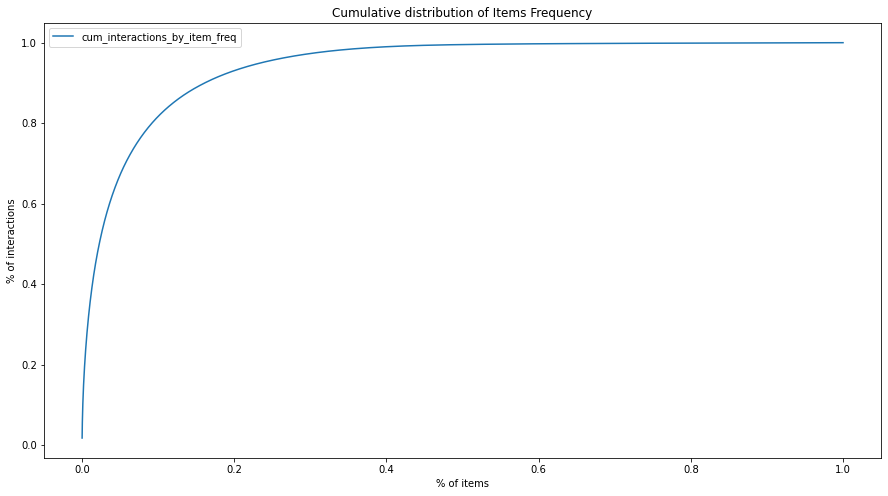

In [52]:
ax = items_freq_cum_perc_pdf.plot.line(figsize=(15,8))

ax.set_title('Cumulative distribution of Items Frequency')
ax.set_ylabel('% of interactions')
ax.set_xlabel('% of items')

In [53]:
#Reindexing the distribution by 1% increments
items_freq_cum_perc_reindexed_pdf = items_freq_cum_perc_pdf.reindex(np.arange(0.0, 1.01, 0.01), method='pad').fillna(0.)
items_freq_cum_perc_reindexed_pdf.head()

,cum_interactions_by_item_freq
cum_perc_items,
0.00,0.000000
0.01,0.346676
0.02,0.475619
0.03,0.560342
0.04,0.622834


In [54]:
#Extracting some percentiles to save
items_freq_cum_perc_selected_pdf = items_freq_cum_perc_reindexed_pdf.loc[[0.01, 0.05, 0.10, 0.25, 0.50]]
dataset_info['top-01%_item_cum_freq'] = items_freq_cum_perc_selected_pdf.loc[0.01][0]
dataset_info['top-05%_item_cum_freq'] = items_freq_cum_perc_selected_pdf.loc[0.05][0]
dataset_info['top-10%_item_cum_freq'] = items_freq_cum_perc_selected_pdf.loc[0.10][0]
dataset_info['top-25%_item_cum_freq'] = items_freq_cum_perc_selected_pdf.loc[0.25][0]
dataset_info['top-50%_item_cum_freq'] = items_freq_cum_perc_selected_pdf.loc[0.50][0]
items_freq_cum_perc_selected_pdf

,cum_interactions_by_item_freq
cum_perc_items,
0.01,0.346676
0.05,0.671942
0.10,0.816871
0.25,0.956490
0.50,0.995338


In [55]:
items_freq_percentiles_df = items_freq_df['freq'].describe(percentiles=PERCENTILES)
set_distr_percentiles(items_freq_percentiles_df, dataset_info, prefix='item_freq')
items_freq_percentiles_df

count     57483.000000
mean        181.472975
std        1094.340898
min           1.000000
0%            1.000000
10%           1.000000
20%           1.000000
25%           1.000000
30%           1.000000
40%           2.000000
50%           5.000000
60%          17.000000
70%          48.000000
75%          74.000000
80%         118.000000
90%         350.800000
95%         801.000000
99%        3019.540000
100%     180031.000000
max      180031.000000
Name: freq, dtype: float64

Text(0.5, 1.0, 'Items Frequency histogram')

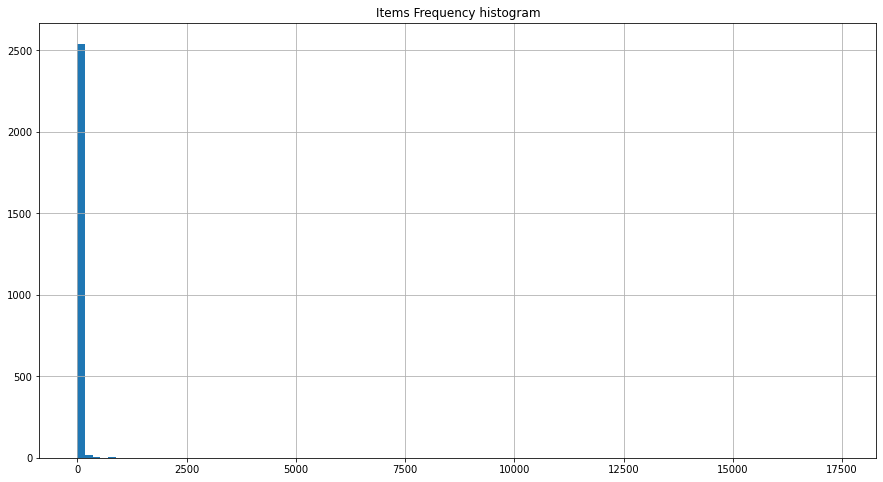

In [56]:
ax = items_freq_df.groupby('freq').size().to_pandas().hist(bins=100, figsize=(15,8))
ax.set_title('Items Frequency histogram')

### # Interactions per User distribution

In [57]:
%%time
if HAS_USER:
    user_freq_series = ddf.groupby('UserId').size().compute()
    display(user_freq_series.head(10))

CPU times: user 2 µs, sys: 4 µs, total: 6 µs
Wall time: 10.7 µs


In [58]:
if HAS_USER:
    users_freq_gini_index = gini_index_cupy(user_freq_series.values.astype('float'))
else:
    users_freq_gini_index = None
dataset_info['users_freq_gini_index'] = users_freq_gini_index

In [59]:
%%time
if HAS_USER:
    users_freq_df = ddf.groupby('UserId').size().to_frame('freq').compute().sort_values('freq', ascending=False)
    display(users_freq_df.head(10))

CPU times: user 13 µs, sys: 0 ns, total: 13 µs
Wall time: 24.1 µs


In [60]:
%%time
if HAS_USER:
    users_freq_cum_perc = (users_freq_df['freq'].cumsum() / users_freq_df['freq'].sum()).to_frame('cum_interactions_by_user_freq')
    users_freq_cum_perc['dummy'] = 1
    users_freq_cum_perc['cum_perc_users'] = users_freq_cum_perc['dummy'].cumsum() / users_freq_cum_perc['dummy'].sum()
    del users_freq_cum_perc['dummy']
    display(users_freq_cum_perc)

CPU times: user 12 µs, sys: 0 ns, total: 12 µs
Wall time: 23.8 µs


In [61]:
if HAS_USER:
    users_freq_cum_perc_pdf = users_freq_cum_perc.set_index('cum_perc_users').to_pandas()

In [62]:
if HAS_USER:
    ax = users_freq_cum_perc_pdf.plot.line(figsize=(15,8))

    ax.set_title('Cumulative distribution of Users Frequency')
    ax.set_ylabel('% of interactions')
    ax.set_xlabel('% of users')

In [63]:
if HAS_USER:
    users_freq_cum_perc_reindexed_pdf = users_freq_cum_perc_pdf.reindex(np.arange(0.0, 1.01, 0.01), method='pad').fillna(0.)
    display(users_freq_cum_perc_reindexed_pdf.head())

In [64]:
if HAS_USER:
    users_freq_cum_perc_selected_pdf = users_freq_cum_perc_reindexed_pdf.reindex(np.arange(0.0, 1.01, 0.01), method='pad') \
                            .loc[[0.01, 0.05, 0.10, 0.25, 0.50]]
    dataset_info['top-01%_user_cum_freq'] = users_freq_cum_perc_selected_pdf.loc[0.01][0]
    dataset_info['top-05%_user_cum_freq'] = users_freq_cum_perc_selected_pdf.loc[0.05][0]
    dataset_info['top-10%_user_cum_freq'] = users_freq_cum_perc_selected_pdf.loc[0.10][0]
    dataset_info['top-25%_user_cum_freq'] = users_freq_cum_perc_selected_pdf.loc[0.25][0]
    dataset_info['top-50%_user_cum_freq'] = users_freq_cum_perc_selected_pdf.loc[0.50][0]
    users_freq_cum_perc_selected_pdf
else:
    dataset_info['top-01%_user_cum_freq'] = None
    dataset_info['top-05%_user_cum_freq'] = None
    dataset_info['top-10%_user_cum_freq'] = None
    dataset_info['top-25%_user_cum_freq'] = None
    dataset_info['top-50%_user_cum_freq'] = None

In [65]:
if HAS_USER:
    users_freq_percentiles_df = users_freq_df['freq'].describe(percentiles=PERCENTILES)
else:    
    users_freq_percentiles_df = None
    
set_distr_percentiles(users_freq_percentiles_df, dataset_info, prefix='user_freq')
display(users_freq_percentiles_df)

None

In [66]:
if HAS_USER:
    ax = users_freq_df.groupby('freq').size().to_pandas().hist(bins=100, figsize=(15,8))
    ax.set_title('Users Frequency histogram')

### # User-Item repeated interaction distribution

In [67]:
%%time
if HAS_USER:
    items_per_user_df = ddf.groupby('UserId')['ItemId'].size().to_frame('count')
    display(items_per_user_df)

CPU times: user 5 µs, sys: 8 µs, total: 13 µs
Wall time: 24.3 µs


In [68]:
%%time
if HAS_USER:
    unique_items_per_user_df = ddf[['UserId', 'ItemId']].drop_duplicates().groupby('UserId').size().to_frame('nunique')
    display(unique_items_per_user_df)

CPU times: user 13 µs, sys: 0 ns, total: 13 µs
Wall time: 24.6 µs


In [69]:
%%time
if HAS_USER:
    items_per_user_joined_df = items_per_user_df.merge(unique_items_per_user_df)
    items_per_user_joined_df['user_perc_repeated_interactions'] = (items_per_user_joined_df['count'] - items_per_user_joined_df['nunique']) / items_per_user_joined_df['count']
    display(items_per_user_joined_df)

CPU times: user 12 µs, sys: 0 ns, total: 12 µs
Wall time: 21 µs


In [70]:
%%time
if HAS_USER:
    repeat_user_item_interactions_percentiles_df = \
            items_per_user_joined_df['user_perc_repeated_interactions'].describe(percentiles=PERCENTILES).compute()
else:
    repeat_user_item_interactions_percentiles_df = None
set_distr_percentiles(repeat_user_item_interactions_percentiles_df, dataset_info, prefix='user_perc_repeated_interactions', dtype='float')
display(repeat_user_item_interactions_percentiles_df)

None

CPU times: user 6.35 ms, sys: 0 ns, total: 6.35 ms
Wall time: 5.3 ms


## Temporal aspects

### # Interactions per day, week, month

CPU times: user 219 ms, sys: 32.3 ms, total: 251 ms
Wall time: 1.07 s


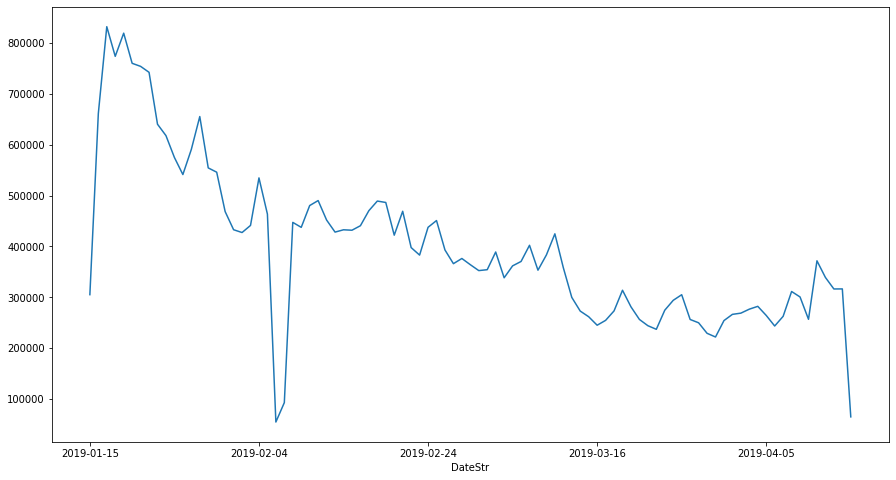

In [71]:
%%time
if HAS_TIMESTAMP:
    ddf.groupby('DateStr').size().compute().to_pandas().sort_index().plot.line(figsize=(15,8))

CPU times: user 245 ms, sys: 14 ms, total: 259 ms
Wall time: 1.09 s


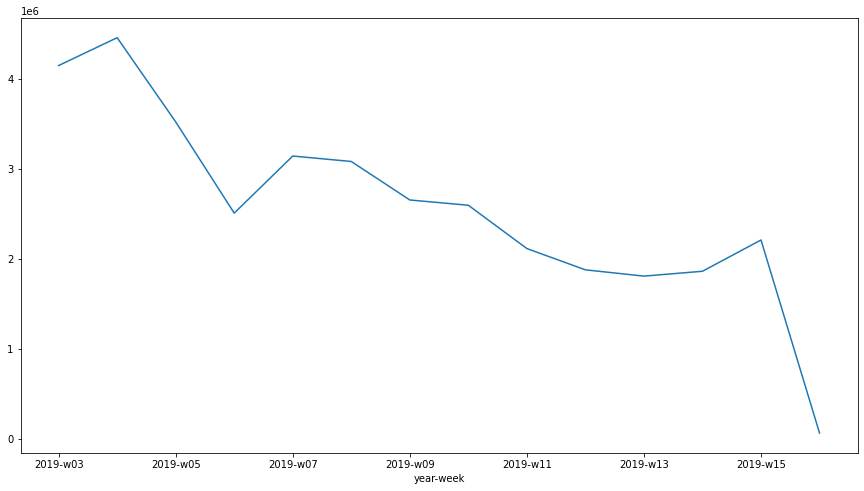

In [72]:
%%time
if HAS_TIMESTAMP:
    ddf.groupby('year-week').size().compute().to_pandas().sort_index().plot.line(figsize=(15,8))

CPU times: user 214 ms, sys: 43.7 ms, total: 257 ms
Wall time: 1.11 s


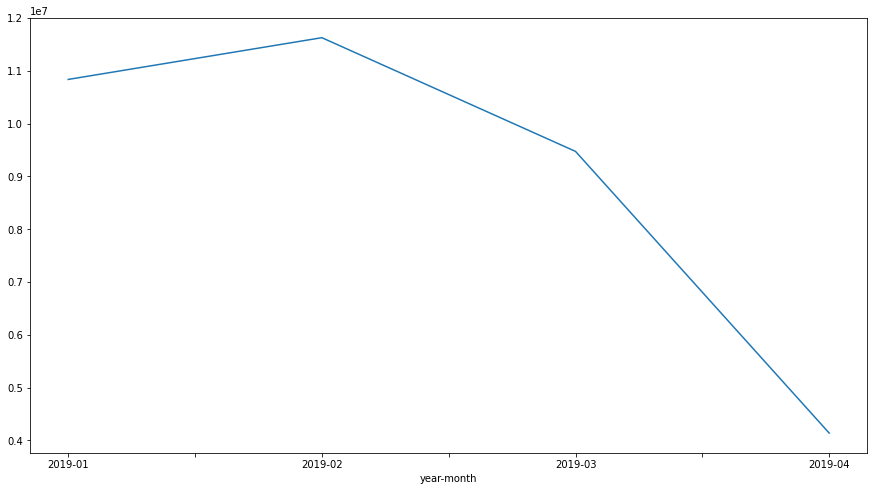

In [73]:
%%time
if HAS_TIMESTAMP:
    ddf.groupby('year-month').size().compute().to_pandas().sort_index().plot.line(figsize=(15,8))

### Items lifetime: Items interactions decay over time

In [74]:
%%time
if HAS_TIMESTAMP:
    # Getting the first time each item was seen in the dataset
    first_date_item_df = ddf.groupby('ItemId')[['Time', 'DateStr', 'year-week', 'year-month']].min()
    first_date_item_df = first_date_item_df.compute().rename(
                              {'Time': 'first_Time',
                               'DateStr': 'first_DateStr',
                               'year-week': 'first_year-week',
                               'year-month': 'first_year-month'}, axis=1)

CPU times: user 193 ms, sys: 30.9 ms, total: 224 ms
Wall time: 1.19 s


In [75]:
%%time
if HAS_TIMESTAMP:
    #Computing for each interaction how many days since the item was first seen
    item_interactions_time_df = ddf[['ItemId', 'Time']].merge(first_date_item_df, left_on='ItemId', right_index=True)#.compute()
    item_interactions_time_df['item_elapsed_days_since_first_seen'] = (item_interactions_time_df['Time'] - item_interactions_time_df['first_Time']).dt.days
    display(item_interactions_time_df.head())

,ItemId,Time,first_Time,first_DateStr,first_year-week,first_year-month,item_elapsed_days_since_first_seen
57178,479b174174e35e57bc3bba70d5a3d233c81d3046cd2e2d...,2019-02-22 00:18:12.574,2019-01-15 12:43:40.924,2019-01-15,2019-w03,2019-01,37
54413,58e6ca785d4e2af324f1958e4ac3c7ba22c0bf879d670d...,2019-03-04 21:11:20.929,2019-01-15 17:11:26.891,2019-01-15,2019-w03,2019-01,48
6669,b56e3b1c25a717834c5399f098cdcd61223ca992f76e70...,2019-02-28 00:10:51.479,2019-01-15 15:35:14.408,2019-01-15,2019-w03,2019-01,43
6679,46be38ef60a9867925da0055be7783d1e23bc4bb25f3ad...,2019-02-28 00:16:33.765,2019-01-30 09:45:03.133,2019-01-30,2019-w05,2019-01,28
7628,6f83e8f895bf4f96d5d1bc480b40f3a0969d06064f84f2...,2019-03-09 00:28:53.295,2019-01-15 23:10:22.817,2019-01-15,2019-w03,2019-01,52


CPU times: user 133 ms, sys: 8.02 ms, total: 141 ms
Wall time: 209 ms


In [76]:
%%time
if HAS_TIMESTAMP:
    item_elapsed_days_since_available_describe_df = item_interactions_time_df['item_elapsed_days_since_first_seen'] \
                                    .describe(percentiles=PERCENTILES).compute()
    set_distr_percentiles(item_elapsed_days_since_available_describe_df, dataset_info, prefix='item_interactions_by_age_days')
    display(item_elapsed_days_since_available_describe_df)

count    1.043161e+07
mean     3.427496e+01
std      2.506770e+01
min      0.000000e+00
0%       0.000000e+00
10%      6.000000e+00
20%      1.100000e+01
25%      1.400000e+01
30%      1.700000e+01
40%      2.600000e+01
50%      3.500000e+01
60%      4.200000e+01
70%      5.200000e+01
75%      5.600000e+01
80%      6.400000e+01
90%      7.900000e+01
95%      8.500000e+01
99%      8.800000e+01
100%     8.900000e+01
max      8.900000e+01
Name: item_elapsed_days_since_first_seen, dtype: float64

CPU times: user 799 ms, sys: 72.7 ms, total: 872 ms
Wall time: 2.31 s


CPU times: user 678 ms, sys: 53.6 ms, total: 731 ms
Wall time: 1.94 s


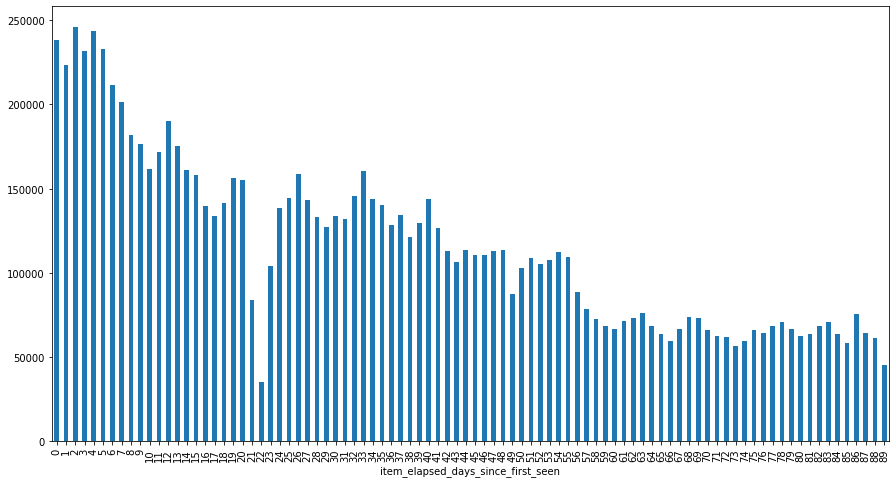

In [77]:
%%time
if HAS_TIMESTAMP:
    item_interactions_time_df.groupby('item_elapsed_days_since_first_seen').size().compute() \
                .to_pandas().sort_index().plot.bar(figsize=(15,8))

### Item Cold-start

#### How many new items every week / month

In [78]:
%%time
if HAS_TIMESTAMP:
    new_items_by_day = first_date_item_df.groupby('first_DateStr').size().to_pandas()
    display(new_items_by_day)

first_DateStr
2019-01-15    10271
2019-01-16     4999
2019-01-17     3080
2019-01-18     2125
2019-01-19     1683
              ...  
2019-04-11      716
2019-04-12      551
2019-04-13      537
2019-04-14      478
2019-04-15       98
Length: 90, dtype: int32

CPU times: user 14.4 ms, sys: 14 ms, total: 28.4 ms
Wall time: 26.3 ms


In [79]:
%%time
if HAS_TIMESTAMP:
    #Ignoring first day
    dataset_info['new_items_by_day_p50'] = new_items_by_day[1:].median()
    print(dataset_info['new_items_by_day_p50'])

356.0
CPU times: user 3.94 ms, sys: 108 µs, total: 4.05 ms
Wall time: 3.36 ms


<AxesSubplot:xlabel='first_DateStr'>

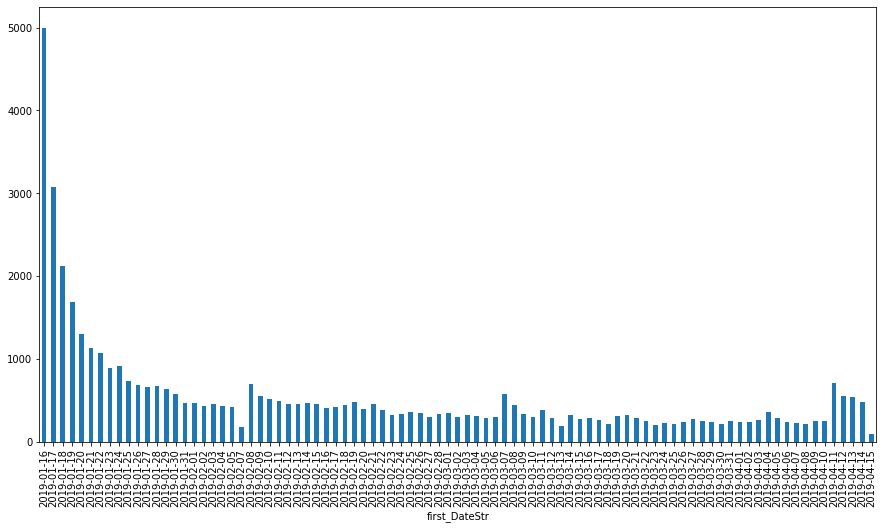

In [80]:
if HAS_TIMESTAMP:
    display(new_items_by_day[1:].sort_index().plot.bar(figsize=(15,8)))

In [81]:
%%time
if HAS_TIMESTAMP:
    new_items_by_week = first_date_item_df.groupby('first_year-week').size().to_pandas()
    display(new_items_by_week)

first_year-week
2019-w03    23459
2019-w04     6110
2019-w05     3720
2019-w06     2794
2019-w07     3188
2019-w08     2834
2019-w09     2315
2019-w10     2569
2019-w11     2020
2019-w12     1820
2019-w13     1694
2019-w14     1855
2019-w15     3007
2019-w16       98
dtype: int32

CPU times: user 21.2 ms, sys: 4.03 ms, total: 25.2 ms
Wall time: 22.5 ms


In [82]:
if HAS_TIMESTAMP:
    dataset_info['new_items_by_week_p50'] = new_items_by_week[1:].median()
    print(dataset_info['new_items_by_week_p50'])

2569.0


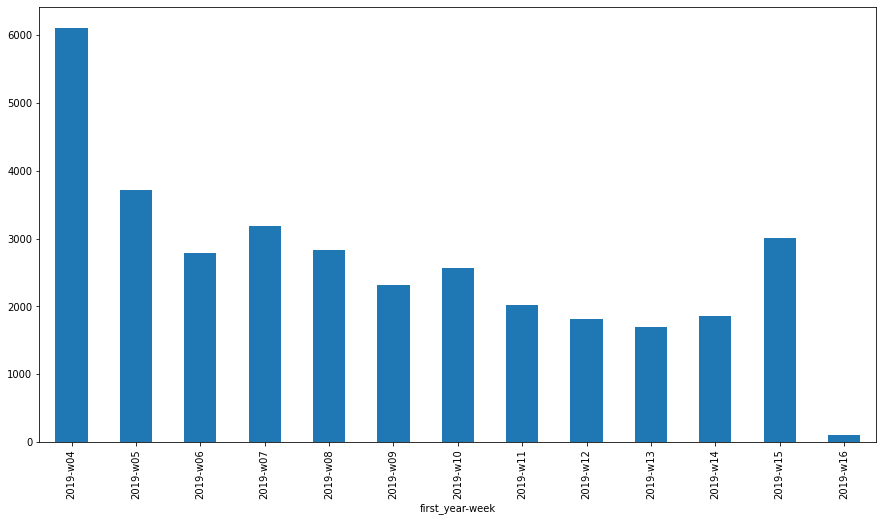

In [83]:
if HAS_TIMESTAMP:
    if len(new_items_by_week[1:]) > 0:
        new_items_by_week[1:].sort_index().plot.bar(figsize=(15,8))

In [84]:
%%time
if HAS_TIMESTAMP:
    new_items_by_month = first_date_item_df.groupby('first_year-month').size().to_pandas()
    display(new_items_by_month)

first_year-month
2019-01    31924
2019-02    11529
2019-03     9070
2019-04     4960
dtype: int32

CPU times: user 30 ms, sys: 0 ns, total: 30 ms
Wall time: 26.9 ms


In [85]:
%%time
if HAS_TIMESTAMP:
    #Ignoring first month
    dataset_info['new_items_by_month_p50'] = new_items_by_month[1:].median()
    print(dataset_info['new_items_by_month_p50'])

9070.0
CPU times: user 1.97 ms, sys: 0 ns, total: 1.97 ms
Wall time: 1.88 ms


CPU times: user 41.4 ms, sys: 15.8 ms, total: 57.2 ms
Wall time: 53.2 ms


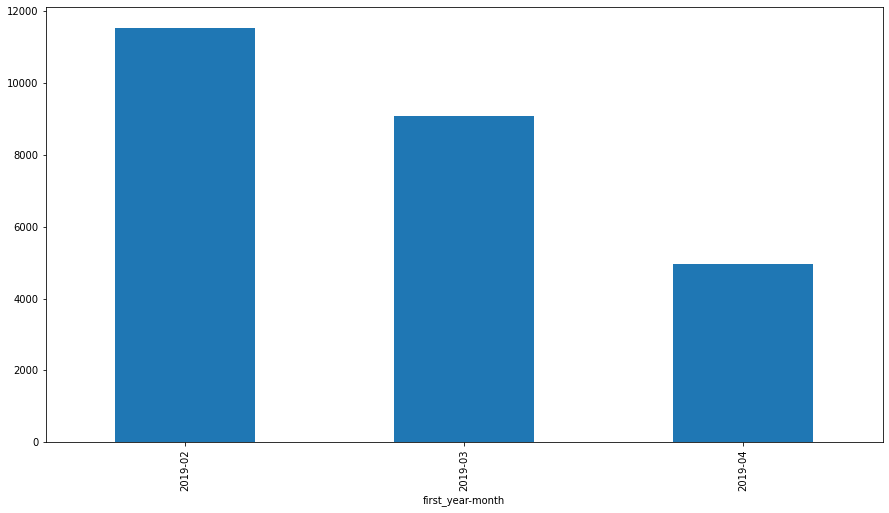

In [86]:
%%time
if HAS_TIMESTAMP:
    if len(new_items_by_month[1:]) > 0:
        new_items_by_month[1:].sort_index().plot.bar(figsize=(15,8))

#### % of interactions on new items first seen in the same day, week, month

In [87]:
%%time
if HAS_TIMESTAMP:
    item_cold_start_df = ddf.merge(first_date_item_df,  left_on='ItemId', right_index=True)[['DateStr', 'first_DateStr',
                                                                        'year-week', 'first_year-week',
                                                                        'year-month', 'first_year-month']] #.compute()
    min_year_week = item_cold_start_df['year-week'].compute().min()
    #Ignoring first week (where most of the items will occur first)
    item_cold_start_df = item_cold_start_df[item_cold_start_df['year-week'] != min_year_week]
    #Checking if the item was created in the same day, week or month of the interaction
    item_cold_start_df['item_created_same_day'] = (item_cold_start_df['DateStr'] == item_cold_start_df['first_DateStr'])
    item_cold_start_df['item_created_same_week'] = (item_cold_start_df['year-week'] == item_cold_start_df['first_year-week'])
    item_cold_start_df['item_created_same_month'] = (item_cold_start_df['year-month'] == item_cold_start_df['first_year-month'])

CPU times: user 464 ms, sys: 443 ms, total: 907 ms
Wall time: 1.93 s


In [88]:
%%time
if HAS_TIMESTAMP:
    perc_interactions_on_items_created_same_day = item_cold_start_df['item_created_same_day'].mean().compute()
    dataset_info['perc_interact_items_created_same_day'] = perc_interactions_on_items_created_same_day
    print(perc_interactions_on_items_created_same_day)

0.0054483721421596425
CPU times: user 257 ms, sys: 41.1 ms, total: 299 ms
Wall time: 1.39 s


In [89]:
%%time
if HAS_TIMESTAMP:
    perc_interactions_on_items_created_same_week = item_cold_start_df['item_created_same_week'].mean().compute()
    dataset_info['perc_interact_items_created_same_week'] = perc_interactions_on_items_created_same_week
    print(perc_interactions_on_items_created_same_week)

0.012125196480810962
CPU times: user 595 ms, sys: 63 ms, total: 658 ms
Wall time: 2.07 s


In [90]:
%%time
if HAS_TIMESTAMP:
    perc_interactions_on_items_created_same_month = item_cold_start_df['item_created_same_month'].mean().compute()
    dataset_info['perc_interact_items_created_same_month'] = perc_interactions_on_items_created_same_month
    print(perc_interactions_on_items_created_same_month)

0.2216688682845142
CPU times: user 601 ms, sys: 46.7 ms, total: 648 ms
Wall time: 2.06 s


### Users lifetime: User interactions decay over time

In [91]:
%%time
if HAS_USER and HAS_TIMESTAMP:
    first_date_user_df = ddf.groupby('UserId')[['Time', 'DateStr', 'year-week', 'year-month']].min()
    first_date_user_df = first_date_user_df.compute().rename(
                              {'Time': 'first_Time',
                               'DateStr': 'first_DateStr',
                               'year-week': 'first_year-week',
                               'year-month': 'first_year-month'}, axis=1)
    display(first_date_user_df)

CPU times: user 14 µs, sys: 0 ns, total: 14 µs
Wall time: 25.5 µs


In [92]:
%%time
if HAS_USER and  HAS_TIMESTAMP:
    user_interactions_time_df = ddf[['UserId', 'Time']].merge(first_date_user_df, left_on='UserId', right_index=True) #.compute()
    user_interactions_time_df['user_elapsed_days_since_first_seen'] = (user_interactions_time_df['Time'] - user_interactions_time_df['first_Time']).dt.days

CPU times: user 14 µs, sys: 0 ns, total: 14 µs
Wall time: 25.5 µs


In [93]:
%%time
if HAS_USER and HAS_TIMESTAMP:
    user_elapsed_days_since_first_seen_describe_df = \
            user_interactions_time_df['user_elapsed_days_since_first_seen'].describe(percentiles=PERCENTILES).compute()
else:
    user_elapsed_days_since_first_seen_describe_df = None
    
set_distr_percentiles(user_elapsed_days_since_first_seen_describe_df, dataset_info, prefix='user_interactions_by_age_days')
display(user_elapsed_days_since_first_seen_describe_df)

None

CPU times: user 897 µs, sys: 5.13 ms, total: 6.03 ms
Wall time: 4.84 ms


In [94]:
%%time
if HAS_USER and HAS_TIMESTAMP:
    user_interactions_time_df.groupby('user_elapsed_days_since_first_seen').size().compute().to_pandas().sort_index().plot.bar(figsize=(15,8))#

CPU times: user 12 µs, sys: 0 ns, total: 12 µs
Wall time: 21.9 µs


### User Cold-start

#### How many new items every week / month

In [95]:
%%time
if HAS_USER and HAS_TIMESTAMP:
    new_users_by_day = first_date_user_df.groupby('first_DateStr').size()
    display(new_users_by_day)

CPU times: user 7 µs, sys: 7 µs, total: 14 µs
Wall time: 24.6 µs


In [96]:
%%time
if HAS_USER and HAS_TIMESTAMP:
    #Ignoring first day
    dataset_info['new_users_by_day_p50'] = new_users_by_day[1:].median()
    print(dataset_info['new_users_by_day_p50'])
else:
    dataset_info['new_users_by_day_p50'] = None

CPU times: user 4 µs, sys: 4 µs, total: 8 µs
Wall time: 13.8 µs


In [97]:
%%time
if HAS_USER and HAS_TIMESTAMP:
    new_users_by_week = first_date_user_df.groupby('first_year-week').size().to_pandas()
    display(new_users_by_week)

CPU times: user 7 µs, sys: 6 µs, total: 13 µs
Wall time: 24.1 µs


In [98]:
%%time
if HAS_USER and HAS_TIMESTAMP:
    #Ignoring first week
    dataset_info['new_users_by_week_p50'] = new_users_by_week[1:].median()
    print(dataset_info['new_users_by_week_p50'])
else:
    dataset_info['new_users_by_week_p50'] = None

CPU times: user 11 µs, sys: 10 µs, total: 21 µs
Wall time: 32.7 µs


In [99]:
%%time
if HAS_USER and HAS_TIMESTAMP:
    if len(new_users_by_week[1:]) > 0:
        new_users_by_week[1:].sort_index().plot.bar(figsize=(15,8))

CPU times: user 4 µs, sys: 4 µs, total: 8 µs
Wall time: 21 µs


In [100]:
%%time
if HAS_USER and HAS_TIMESTAMP:
    new_users_by_month = first_date_user_df.groupby('first_year-month').size().to_pandas()
    display(new_users_by_month)

CPU times: user 13 µs, sys: 0 ns, total: 13 µs
Wall time: 23.6 µs


In [101]:
if HAS_USER and HAS_TIMESTAMP:
    #Ignoring first month
    dataset_info['new_users_by_month_p50'] = new_users_by_month[1:].median()
    print(dataset_info['new_users_by_month_p50'])
else:
    dataset_info['new_users_by_month_p50'] = None

In [102]:
if HAS_USER and HAS_TIMESTAMP:
    if len(new_users_by_month[1:]) > 0:
        new_users_by_month[1:].sort_index().plot.bar(figsize=(15,8))

#### % of interactions on new items first seen in the same day, week, month

In [103]:
%%time
if HAS_USER and HAS_TIMESTAMP:
    user_cold_start_df = ddf.merge(first_date_user_df,  left_on='UserId', right_index=True)[['DateStr', 'first_DateStr',
                                                                        'year-week', 'first_year-week',
                                                                        'year-month', 'first_year-month']] #.compute()
    min_year_week = user_cold_start_df['year-week'].compute().min()
    #Ignoring first week (where most of the items will occur first)
    user_cold_start_df = user_cold_start_df[user_cold_start_df['year-week'] != min_year_week]
    #Checking if the item was created in the same day, week or month of the interaction
    user_cold_start_df['user_created_same_day'] = (user_cold_start_df['DateStr'] == user_cold_start_df['first_DateStr'])
    user_cold_start_df['user_created_same_week'] = (user_cold_start_df['year-week'] == user_cold_start_df['first_year-week'])
    user_cold_start_df['user_created_same_month'] = (user_cold_start_df['year-month'] == user_cold_start_df['first_year-month'])

CPU times: user 8 µs, sys: 0 ns, total: 8 µs
Wall time: 14.1 µs


In [104]:
%%time
if HAS_USER and HAS_TIMESTAMP:
    perc_interactions_by_users_first_seen_same_day = user_cold_start_df['user_created_same_day'].mean().compute()
    dataset_info['perc_interact_users_created_same_day'] = perc_interactions_by_users_first_seen_same_day
    print(perc_interactions_by_users_first_seen_same_day)
else:
    dataset_info['perc_interact_users_created_same_day'] = None

CPU times: user 8 µs, sys: 8 µs, total: 16 µs
Wall time: 26.2 µs


In [105]:
%%time
if HAS_USER and HAS_TIMESTAMP:
    perc_interactions_by_users_first_seen_same_week = user_cold_start_df['user_created_same_week'].mean().compute()
    dataset_info['perc_interact_users_created_same_week'] = perc_interactions_by_users_first_seen_same_week
    print(perc_interactions_by_users_first_seen_same_week)
else:
    dataset_info['perc_interact_users_created_same_week'] = None

CPU times: user 8 µs, sys: 8 µs, total: 16 µs
Wall time: 26.2 µs


In [106]:
%%time
if HAS_USER and HAS_TIMESTAMP:
    perc_interactions_by_users_first_seen_same_month = user_cold_start_df['user_created_same_month'].mean().compute()
    dataset_info['perc_interact_users_created_same_month'] = perc_interactions_by_users_first_seen_same_month
    print(perc_interactions_by_users_first_seen_same_month)
else:
    dataset_info['perc_interact_users_created_same_month'] = None

CPU times: user 16 µs, sys: 0 ns, total: 16 µs
Wall time: 26.7 µs


## Sessions stats

### Session length distribution

In [107]:
%%time
if HAS_SESSION_ID:
    sessions_length = ddf.groupby('SessionId').size()
    session_length_describe_df = sessions_length.describe(percentiles=PERCENTILES).compute()
else:
    session_length_describe_df = None
set_distr_percentiles(session_length_describe_df, dataset_info, prefix='session_length')
display(session_length_describe_df)

count    4.934699e+06
mean     7.311349e+00
std      1.229165e+01
min      1.000000e+00
0%       1.000000e+00
10%      1.000000e+00
20%      2.000000e+00
25%      2.000000e+00
30%      2.000000e+00
40%      2.000000e+00
50%      3.000000e+00
60%      4.000000e+00
70%      6.000000e+00
75%      8.000000e+00
80%      1.000000e+01
90%      1.700000e+01
95%      2.700000e+01
99%      6.000000e+01
100%     2.060000e+02
max      2.060000e+02
dtype: float64

CPU times: user 295 ms, sys: 66 ms, total: 361 ms
Wall time: 1.69 s


### Session duration distribution

In [108]:
%%time
if HAS_SESSION_ID and HAS_TIMESTAMP:
    sessions_df = ddf.groupby('SessionId')['Time'].agg(['min', 'max'])#.compute()
    sessions_df['session_duration_min'] = (sessions_df['max'] - sessions_df['min']).dt.seconds / 60
    session_duration_describe_df = sessions_df['session_duration_min'].describe(percentiles=PERCENTILES).compute()
else:
    session_duration_describe_df = None
set_distr_percentiles(session_duration_describe_df, dataset_info, prefix='session_duration_min')
display(session_duration_describe_df)

count    4.934699e+06
mean     3.514354e+00
std      8.451696e+00
min      0.000000e+00
0%       0.000000e+00
10%      0.000000e+00
20%      0.000000e+00
25%      0.000000e+00
30%      0.000000e+00
40%      0.000000e+00
50%      3.666667e-01
60%      9.500000e-01
70%      2.016667e+00
75%      2.900000e+00
80%      4.216667e+00
90%      1.028333e+01
95%      1.886667e+01
99%      3.951667e+01
100%     5.881333e+02
max      5.881333e+02
Name: session_duration_min, dtype: float64

CPU times: user 496 ms, sys: 49.7 ms, total: 546 ms
Wall time: 4.09 s


### Session by user distribution

In [109]:
%%time
if HAS_USER and HAS_SESSION_ID:
    sessions_by_user_df = ddf.groupby('UserId')['SessionId'].size().to_frame('count').compute()
    sessions_by_user_distr_df = sessions_by_user_df['count'].describe(percentiles=PERCENTILES)
else:
    sessions_by_user_distr_df = None
set_distr_percentiles(sessions_by_user_distr_df, dataset_info, prefix='sessions_by_user')
display(sessions_by_user_distr_df)

None

CPU times: user 4.79 ms, sys: 437 µs, total: 5.23 ms
Wall time: 4.39 ms


### Interval between user sessions distribution

In [110]:
%%time
if HAS_USER and HAS_SESSION_ID and HAS_TIMESTAMP:
    sessions_start_ts_df = ddf.groupby(['UserId', 'SessionId'])['Time'].agg(['min', 'max']).reset_index().compute() \
                            .rename({'min': 'session_start', 'max': 'session_end'}, axis=1) \
                            .sort_values(['UserId', 'session_start'], ascending=True)
    
    sessions_start_ts_df['prev_session_end'] = sessions_start_ts_df['session_end'].shift(1)
    sessions_start_ts_df['days_since_last_session'] = (sessions_start_ts_df['session_start'] - \
                                                       sessions_start_ts_df['prev_session_end']).dt.days
    sessions_start_ts_df['hours_since_last_session'] = (sessions_start_ts_df['session_start'] - \
                                                        sessions_start_ts_df['prev_session_end']).dt.seconds / (60*60)

CPU times: user 14 µs, sys: 0 ns, total: 14 µs
Wall time: 25 µs


In [111]:
%%time
#Shifting UserIds using pandas because cudf does not support shifting String columns yet.
#When cudf starts supporting that you should use just use the shift(1) for that (like columns above)
if HAS_USER and HAS_SESSION_ID and HAS_TIMESTAMP:
    sessions_start_ts_shifted_df = sessions_start_ts_df[1:]    
    sessions_start_ts_shifted_df['prev_user_id'] = sessions_start_ts_df[['UserId']][:-1] \
        .to_pandas()['UserId'].values

CPU times: user 7 µs, sys: 0 ns, total: 7 µs
Wall time: 12.9 µs


In [112]:
%%time
if HAS_USER and HAS_SESSION_ID and HAS_TIMESTAMP:
    # Ignoring the first session of the user
    sessions_start_ts_shifted_df = sessions_start_ts_shifted_df[sessions_start_ts_shifted_df['UserId'] == sessions_start_ts_shifted_df['prev_user_id']]

CPU times: user 13 µs, sys: 0 ns, total: 13 µs
Wall time: 23.4 µs


In [113]:
%%time
if HAS_USER and HAS_SESSION_ID:
    sessions_hours_interval_distr_df = sessions_start_ts_shifted_df['hours_since_last_session'].describe(percentiles=PERCENTILES)
else:
    sessions_hours_interval_distr_df = None
set_distr_percentiles(sessions_hours_interval_distr_df, dataset_info, prefix='sessions_interval_hours')
display(sessions_hours_interval_distr_df)

None

CPU times: user 1.78 ms, sys: 1.62 ms, total: 3.4 ms
Wall time: 2.54 ms


In [114]:
%%time
if HAS_USER and HAS_SESSION_ID:
    sessions_days_interval_distr_df = sessions_start_ts_shifted_df['days_since_last_session'].describe(percentiles=PERCENTILES)
else:
    sessions_days_interval_distr_df = None
set_distr_percentiles(sessions_days_interval_distr_df, dataset_info, prefix='sessions_interval_days')
display(sessions_days_interval_distr_df)

None

CPU times: user 4.95 ms, sys: 566 µs, total: 5.51 ms
Wall time: 4.56 ms


# Exporting

## Exporting dataset info profile

In [115]:
dataset_info

OrderedDict([('name', 'coveo'),
             ('domain', 'ecommerce'),
             ('description',
              'Data released for the Coveo Data Challenge (browsing_train.csv)'),
             ('source',
              'https://github.com/coveooss/SIGIR-ecom-data-challenge'),
             ('event_types', 'clicks and Cart-abandonment.'),
             ('has_timestamp', True),
             ('has_session_id', True),
             ('columns',
              'session_id_hash,event_type,product_action,product_sku_hash,server_timestamp_epoch_ms,hashed_url'),
             ('first_date', '2019-01-15'),
             ('last_date', '2019-04-15'),
             ('num_days', 91),
             ('num_interactions', 36079307),
             ('num_items', 57483),
             ('num_users', 0),
             ('num_sessions', 4934699),
             ('sparsity_user_item_matrix', None),
             ('items_freq_gini_index', 0.88493482457111),
             ('top-01%_item_cum_freq', 0.34667569563320566),
         

In [116]:
dataset_info_df = pd.DataFrame.from_dict(dataset_info, orient='index').T
dataset_info_df

,name,domain,description,source,event_types,has_timestamp,has_session_id,columns,first_date,last_date,...,p99_sessions_interval_hours,max_sessions_interval_hours,min_sessions_interval_days,p25_sessions_interval_days,p50_sessions_interval_days,p75_sessions_interval_days,p90_sessions_interval_days,p95_sessions_interval_days,p99_sessions_interval_days,max_sessions_interval_days
0,coveo,ecommerce,Data released for the Coveo Data Challenge (br...,https://github.com/coveooss/SIGIR-ecom-data-ch...,clicks and Cart-abandonment.,True,True,"session_id_hash,event_type,product_action,prod...",2019-01-15,2019-04-15,...,None,None,None,None,None,None,None,None,None,None


In [117]:
print(f'Creating output path if it does not exists: {OUTPUT_PATH}')
os.makedirs(OUTPUT_PATH, exist_ok=True)

Creating output path if it does not exists: dataset_profiles_output/


In [118]:
if SAVE_DATASET_INFO_CSV:
    output_path = os.path.join(OUTPUT_PATH, f"{dataset_info['name']}_dataset_profile.csv")
    print(f'Saving the dataset info to: {output_path}')
    dataset_info_df.to_csv(output_path, index=False)

Saving the dataset info to: dataset_profiles_output/coveo_dataset_profile.csv


## Exporting items and users freq. cumulative distributions

In [119]:
if HAS_USER:
    user_item_cum_freq_distr_df = items_freq_cum_perc_reindexed_pdf.merge(users_freq_cum_perc_reindexed_pdf, 
                                                                          left_index=True, right_index=True)
else:
    user_item_cum_freq_distr_df = items_freq_cum_perc_reindexed_pdf
    user_item_cum_freq_distr_df['cum_interactions_by_user_freq'] = 0.0
user_item_cum_freq_distr_df

,cum_interactions_by_item_freq,cum_interactions_by_user_freq
cum_perc_items,,
0.00,0.000000,0.0
0.01,0.346676,0.0
0.02,0.475619,0.0
0.03,0.560342,0.0
0.04,0.622834,0.0
...,...,...
0.96,0.999780,0.0
0.97,0.999835,0.0
0.98,0.999890,0.0


In [120]:
if SAVE_USERS_ITEMS_CUM_FREQ_DISTR:
    output_path = os.path.join(OUTPUT_PATH, f"{dataset_info['name']}_dataset_user_item_cum_freq_distr.csv")
    print(f'Saving the users and items cumulative freq. distribution to: {output_path}')
    user_item_cum_freq_distr_df.to_csv(output_path)

Saving the users and items cumulative freq. distribution to: dataset_profiles_output/coveo_dataset_user_item_cum_freq_distr.csv
